# Edge Impulse - Spectral Analysis Block
[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mjrovai/TinyML4D/blob/main/AAU/Edge_Impulse_Spectral_Analysis_Block.ipynb)

Implementation_version >= 2
- by Marcelo Rovai @ March23

### Statistical features per axis/channel:
After filtering via a Butterworth IIR filter (if enabled), **the mean is subtracted from the signal.** Several statistical features (RMS, skewness, kurtosis) are calculated from the filtered signal after the mean has been removed. 
- RMS
- Skewness
- Kurtosis

### Spectral features per axis/channel:
The filtered signal is passed to the Spectral power section, which computes the FFT in order to compute the spectral features.
- Maximum value from FFT frames for each bin that was not filtered out
- The total number of features will change, depending on how you set the filter and FFT parameters.

https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features

The Total Number of processed Featues **per axis** will be:
- RMS
- Skewness
- Curtosis
- 1/2 of FFT Lenght (no Filter)

For example, 
- for a FFT Lengh of 16 and filter NONE, the Total Processed Features **per axis** will be 11 (3 + 8)
- for a FFT Lengh of 16 and filter LOW, the Total Processed Features per axis will be lower than 35 depending on Filter Cut-off frequency (LOW: skip everything > cutoff; HIGH: skip everything < cutoff)

## Statistical features

In [84]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.signal import welch
from sklearn import preprocessing

Let's have a datasample from accelerometers (2 seconds window; Sample frequency 62.5Hz)

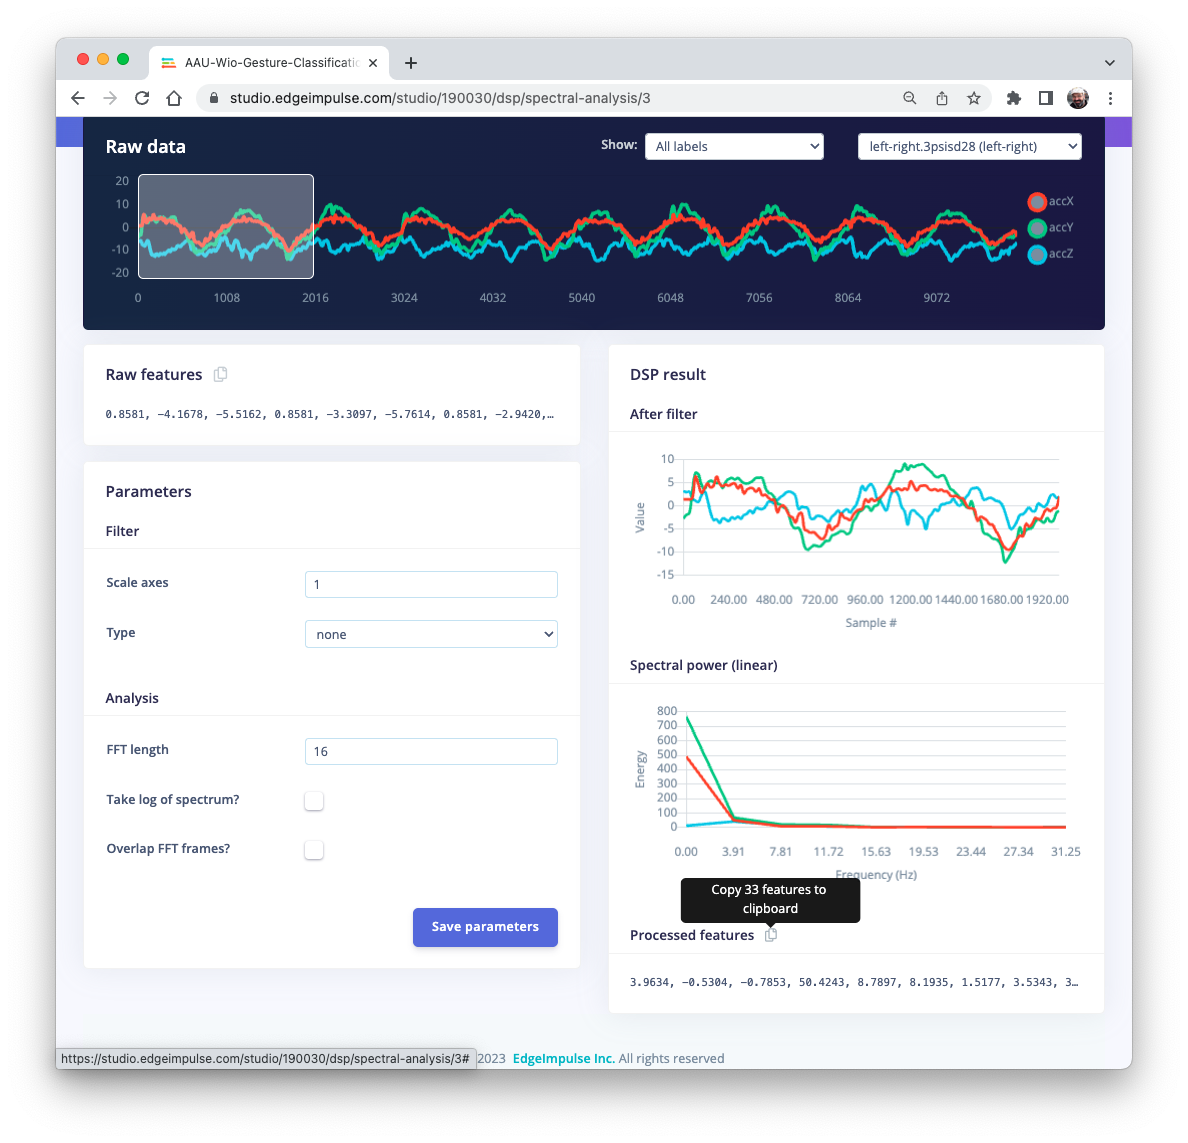

In [85]:
data=[0.8581, -4.1678, -5.5162, 0.8581, -3.3097, -5.7614, 0.8581, -2.9420, -5.6388, 1.1032, 1.8387, -7.1098, 5.7614, 5.7614, -7.6002, 4.0452, 5.3937, -7.8453, 2.2065, 3.1872, -6.3743, 3.3097, 2.2065, -5.5162, 4.2904, 3.5549, -7.4776, 3.4323, 4.0452, -10.1744, 3.8001, 3.8001, -11.7680, 5.7614, 3.5549, -11.6454, 4.1678, 3.4323, -12.3809, 3.6775, 2.4517, -11.4002, 4.0452, 3.8001, -11.6454, 3.8001, 4.4130, -12.0131, 4.1678, 4.6582, -11.1551, 4.2904, 4.2904, -11.5228, 3.1872, 4.6582, -11.0325, 3.9227, 4.0452, -11.5228, 2.0839, 3.5549, -10.6647, 2.9420, 3.4323, -10.4196, 3.3097, 3.6775, -9.6841, 3.1872, 4.0452, -10.2970, 2.4517, 4.6582, -9.1937, 3.1872, 4.6582, -9.3163, 1.7162, 4.6582, -9.4389, 1.8387, 2.6968, -8.9486, 1.2258, 1.4710, -7.8453, 0.7355, 1.2258, -7.8453, 0.7355, 0.4903, -8.2131, -1.9613, -0.8581, -7.4776, -0.7355, -1.1032, -6.8647, -0.4903, -1.7162, -6.3743, -1.4710, -1.9613, -5.7614, -2.6968, -3.8001, -5.6388, -3.0646, -5.7614, -5.8840, -4.1678, -6.2517, -6.6195, -2.4517, -6.1292, -9.4389, -2.0839, -7.4776, -8.9486, -5.6388, -10.1744, -9.0712, -6.0066, -10.9099, -9.1937, -6.3743, -10.4196, -11.4002, -6.2517, -9.9292, -11.5228, -6.8647, -10.0518, -10.9099, -7.4776, -10.1744, -10.9099, -7.7227, -9.6841, -11.1551, -6.7421, -8.9486, -11.7680, -4.6582, -8.9486, -12.1357, -5.7614, -7.8453, -11.0325, -5.1485, -7.6002, -10.5421, -4.6582, -7.2324, -9.6841, -2.2065, -6.8647, -10.4196, -3.0646, -6.9872, -9.8067, -3.3097, -7.4776, -9.4389, -3.6775, -7.1098, -10.1744, -2.5742, -4.9033, -9.3163, -1.7162, -3.9227, -8.4582, -1.3484, -2.6968, -6.6195, -1.2258, -2.3291, -4.4130, 0.8581, -1.5936, -5.3937, 0.2452, -1.5936, -4.4130, 0.9807, -2.4517, -4.0452, 0.4903, -1.4710, -5.1485, 0.8581, -1.2258, -7.4776, 1.3484, 0.2452, -7.6002, 1.9613, 1.2258, -8.9486, 2.9420, 2.0839, -9.6841, 3.6775, 3.3097, -7.2324, 2.5742, 4.5356, -5.5162, 2.9420, 6.1292, -5.5162, 3.1872, 6.0066, -6.4969, 2.8194, 6.2517, -8.9486, 3.1872, 7.7227, -9.9292, 2.9420, 6.3743, -12.7486, 4.7807, 7.3550, -9.9292, 3.6775, 6.9872, -9.6841, 2.6968, 7.3550, -10.2970, 3.6775, 7.4776, -10.9099, 3.8001, 7.6002, -11.6454, 3.8001, 6.9872, -13.7293, 3.0646, 6.3743, -11.1551, 2.8194, 5.7614, -10.4196, 3.0646, 5.0259, -9.4389, 2.6968, 4.7807, -9.8067, 2.9420, 5.1485, -8.4582, 2.5742, 5.1485, -8.3357, 2.5742, 3.8001, -8.0905, 1.7162, 2.3291, -7.9679, 1.4710, 1.9613, -7.2324, 1.5936, 1.2258, -8.0905, 1.1032, 0.4903, -8.7034, 1.1032, -0.6129, -8.0905, 0.1226, -1.3484, -6.9872, -0.9807, -1.8387, -6.2517, -1.1032, -0.3677, -5.0259, -1.3484, -2.6968, -4.9033, -3.8001, -4.4130, -4.7807, -2.9420, -4.5356, -5.6388, -3.1872, -7.2324, -7.3550, -3.6775, -7.4776, -7.2324, -4.5356, -7.8453, -6.9872, -4.6582, -8.4582, -7.1098, -5.8840, -8.5808, -7.6002, -6.9872, -9.0712, -7.7227, -8.5808, -10.4196, -8.3357, -9.5615, -13.6067, -9.9292, -10.0518, -12.8712, -12.0131, -9.8067, -11.6454, -13.7293, -8.7034, -10.5421, -13.2390, -7.8453, -8.7034, -12.1357, -6.9872, -6.0066, -10.6647, -7.1098, -7.7227, -10.5421, -4.4130, -6.6195, -9.8067, -5.0259, -6.3743, -9.0712, -4.5356, -6.1292, -9.8067, -3.1872, -4.9033, -9.8067, -3.4323, -4.2904, -8.2131, -3.3097, -4.6582, -8.5808, -1.9613, -5.0259, -8.9486, -1.2258, -4.0452, -8.2131, -1.7162, -4.7807, -6.6195, -1.1032, -4.6582, -6.2517, -0.9807, -2.9420, -6.9872, 1.4710, -2.4517, -6.7421]

In [86]:
No_raw_features = len(data)
No_raw_features

375

In [87]:
axis = ['accX', 'accY', 'accZ']
n_sensors = len(axis)
n_sensors

3

In [88]:
N = int(No_raw_features/n_sensors)
f = 62.5   # Hertz
wind_sec = 2 # seconds
print (f'Frequency = {f}Hz')
print (f'Window = {wind_sec}s')
print (f'N = {N}')

Frequency = 62.5Hz
Window = 2s
N = 125


In [124]:
# Processed Features
features = [3.9634, -0.5304, -0.7853, 50.4243, 8.7897, 8.1935, 1.5177, 3.5343, 3.3766, 1.9297, 1.5027, 5.7088, -0.1404, -1.2074, 69.0590, 21.2278, 17.7782, 2.7987, 2.6348, 1.9958, 2.1017, 2.5395, 2.2405, 0.0294, -0.7866, 41.5583, 16.4270, 7.1384, 3.8891, 2.4171, 1.9213, 1.8393, 3.6101]

In [125]:
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)
N_feat, N_feat_axis

(33, 11)

- 3 Statistical features per axis --> 9 features 
- 8 Spectral Features (Freq) per axis --> 24
- Total Processed Features = 9+34 = 33

### Split raw data per sensor

In [91]:
accX = data[0::3]
accY = data[1::3]
accZ = data[2::3]

In [92]:
sensors = [accX, accY, accZ]

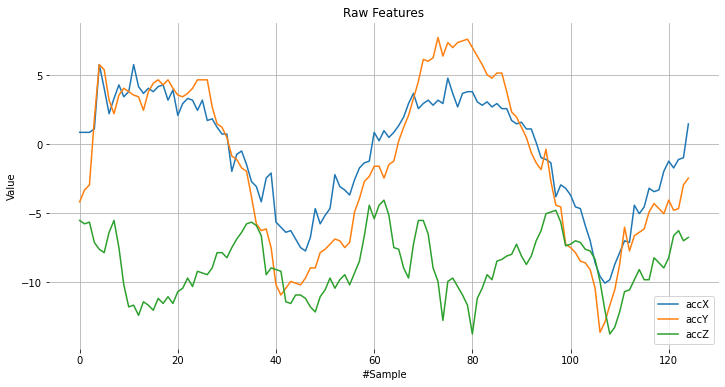

In [93]:
plt.figure(figsize = (12, 6))
[plt.plot(x, label=y) for x,y in zip(sensors, axis)]
plt.legend(loc='lower right')
plt.title('Raw Features')
plt.xlabel('#Sample')
plt.ylabel('Value')
plt.box(False)
plt.grid()
plt.show()

### Subtrating the mean from data
Subtracting the mean from a set of data is a common data pre-processing step in statistics and machine learning. The purpose of subtracting the mean from data is to center the data around zero. This is important because it can reveal patterns and relationships that might be hidden if the data is not centered.

Here are some specific reasons why subtracting the mean can be useful:

- It simplifies analysis: By centering the data, the mean becomes zero, which can make some calculations simpler and easier to interpret.
- It removes bias: If the data has a bias, subtracting the mean can remove that bias and allow for more accurate analysis.
- It can reveal patterns: Centering the data can help reveal patterns that might be hidden if the data is not centered. For example, if you are analyzing a time series dataset, centering the data can help you identify trends over time.
- It can improve performance: In some machine learning algorithms, centering the data can improve performance by reducing the influence of outliers and making the data more easily comparable.
Overall, subtracting the mean is a simple but powerful technique that can be used to improve the analysis and interpretation of data.

In [94]:
dtmean = [(sum(x)/len(x)) for x in sensors]
[print('mean_'+x+'= ', round(y, 4)) for x,y in zip(axis, dtmean)][0]

mean_accX=  -0.6198
mean_accY=  -1.4524
mean_accZ=  -8.7701


In [95]:
accX = [(x - dtmean[0]) for x in accX]
accY = [(x - dtmean[1]) for x in accY]
accZ = [(x - dtmean[2]) for x in accZ]
sensors = [accX, accY, accZ]

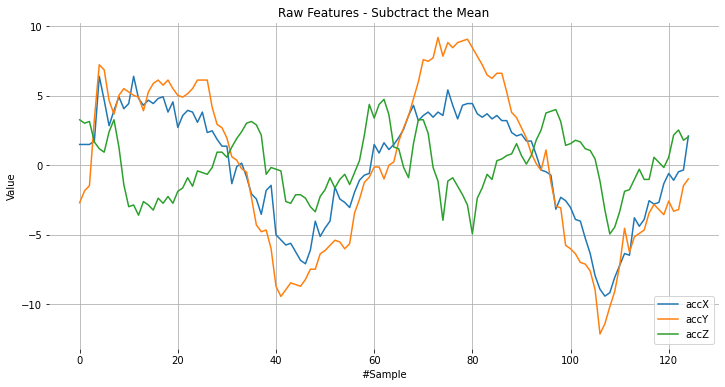

In [96]:
plt.figure(figsize = (12, 6))
[plt.plot(x, label=y) for x,y in zip(sensors, axis)]
plt.legend(loc='lower right')
plt.title('Raw Features - Subctract the Mean')
plt.xlabel('#Sample')
plt.ylabel('Value')
plt.box(False)
plt.grid()
plt.show()

### RMS Calculation

The RMS value of a set of values (or a continuous-time waveform) is the square root of the arithmetic mean of the squares of the values, or the square of the function that defines the continuous waveform. In physics, the RMS current value can also be defined as the "value of the direct current that dissipates the same power in a resistor."

In the case of a set of n values $\{x_{1},x_{2},\dots ,x_{n}\}$, the RMS is:

$\displaystyle x_{\text{RMS}}={\sqrt {{\frac {1}{n}}\left(x_{1}^{2}+x_{2}^{2}+\cdots +x_{n}^{2}\right)}}.$

`NOTE that the RMS value is different for original raw data and after subtracting the mean`

In [97]:
# Using numpy and standartized data (subtracting mean)
rms = [np.sqrt(np.mean(np.square(x))) for x in sensors]
[print('rms_'+x+'= ', round(y, 4)) for x,y in zip(axis, rms)][0]

rms_accX=  3.9634
rms_accY=  5.7088
rms_accZ=  2.2405


In [126]:
# Compare with Edge Impulse result features
features[0:N_feat:N_feat_axis]

[3.9634, 5.7088, 2.2405]

### Skewness and kurtosis calculation

In statistics, skewness and kurtosis are two ways to measure the **shape of a distribution**.

[**Skewness**](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of a distribution. This value can be positive or negative.
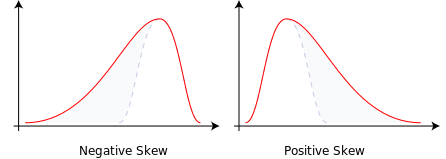
- A negative skew indicates that the tail is on the left side of the distribution, which extends towards more negative values.
- A positive skew indicates that the tail is on the right side of the distribution, which extends towards more positive values.
- A value of zero indicates that there is no skewness in the distribution at all, meaning the distribution is perfectly symmetrical.

[**Kurtosis**](https://en.wikipedia.org/wiki/Kurtosis) is a measure of whether or not a distribution is heavy-tailed or light-tailed relative to a normal distribution.

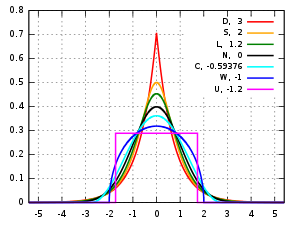
- The kurtosis of a normal distribution is 0.
- If a given distribution has a kurtosis is negative, it is said to be playkurtic, which means it tends to produce fewer and less extreme outliers than the normal distribution.
- If a given distribution has a kurtosis positive, it is said to be leptokurtic, which means it tends to produce more outliers than the normal distribution.

`NOTE that the Skewness and Kurtosis values are the same for original raw data and after subtracting the mean`

Let's see the data distribution and the Skewness and kurtosis calculation

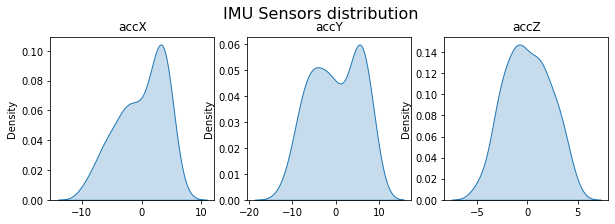

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
sns.kdeplot(accX, fill=True, ax=axes[0])
sns.kdeplot(accY, fill=True, ax=axes[1])
sns.kdeplot(accZ, fill=True, ax=axes[2])
axes[0].set_title('accX')
axes[1].set_title('accY')
axes[2].set_title('accZ')
plt.suptitle('IMU Sensors distribution', fontsize=16, y=1.02)
plt.show()

In [99]:
skew = [skew(x, bias=False) for x in sensors]
[print('skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, skew)][0]

skew_accX=  -0.5369
skew_accY=  -0.1421
skew_accZ=  0.0297


In [127]:
# Compare with Edge Impulse result features
features[1:N_feat:N_feat_axis]

[-0.5304, -0.1404, 0.0294]

In [128]:
kurt = [kurtosis(x, bias=False) for x in sensors]
[print('kurt_'+x+'= ', round(y, 4)) for x,y in zip(axis, kurt)][0]

kurt_accX=  -0.7681
kurt_accY=  -1.2076
kurt_accZ=  -0.7694


In [129]:
# Compare with Edge Impulse result features
features[2:N_feat:N_feat_axis]

[-0.7853, -1.2074, -0.7866]

## Spectral features

In [53]:
FFT_Lenght = 16 
N = 125
fs = 62.5

Once the sampled window usually is larger than the FFT size, the window will be broken into frames (or "sub-windows"), and the FFT is calculated from each frame.

**FFT length** - The FFT size. This determines the number of FFT bins as well as the resolution of frequency peaks that you can separate. A lower number means more signals will average together in the same FFT bin, but also reduces the number of features and model size. A higher number will separate more signals into separate bins, but generates a larger model.

### Welch’s method 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html

To split the signal on frequency domain in bins and calculate the power spectrum for each bin, we should use a method called **Welch’s method**. 

This method divides the signal into overlapping segments, applies a window function to each segment, computes the periodogram of each segment using DFT, and averages them to obtain a smoother estimate of the power spectrum. 

In [130]:
# Function used by Edge Impulse insteady scipy.signal.welch().
def welch_max_hold(fx, sampling_freq, nfft, n_overlap):
    n_overlap = int(n_overlap)
    spec_powers = [0 for _ in range(nfft//2+1)]
    ix = 0
    while ix <= len(fx):
        # Slicing truncates if end_idx > len, and rfft will auto zero pad
        fft_out = np.abs(np.fft.rfft(fx[ix:ix+nfft], nfft))
        spec_powers = np.maximum(spec_powers, fft_out**2/nfft)
        ix = ix + (nfft-n_overlap)
    return np.fft.rfftfreq(nfft, 1/sampling_freq), spec_powers

In [131]:
fax,Pax = welch_max_hold(accX, fs, FFT_Lenght, 0)
fay,Pay = welch_max_hold(accY, fs, FFT_Lenght, 0)
faz,Paz = welch_max_hold(accZ, fs, FFT_Lenght, 0)

Note that since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so we skip it (p[1:])



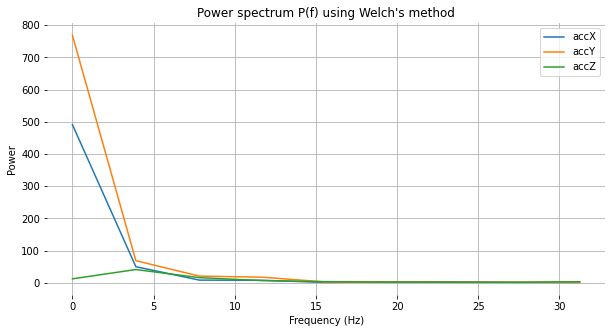

In [132]:
# Plot power spectrum versus frequency 
plt.figure(figsize=(10,5))
# Since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so skip it
plt.plot(fax,Pax, label='accX')
plt.plot(fay,Pay, label='accY')
plt.plot(faz,Paz, label='accZ')

plt.legend(loc='upper right')
plt.xlabel('Frequency (Hz)')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('Power')
plt.title('Power spectrum P(f) using Welch\'s method')
plt.grid()
plt.box(False)
plt.show()

List Spectral features per axis and compare with EI

In [148]:
print("EI Processed features (accX): ")
print(features[3:N_feat_axis][0:])
print("\nCalculated features:")
[print(round(x, 4)) for x in Pax[1:]][0]

EI Processed features (accX): 
[50.4243, 8.7897, 8.1935, 1.5177, 3.5343, 3.3766, 1.9297, 1.5027]

Calculated features:
50.424
8.7899
8.1934
1.5177
3.5343
3.3766
1.9297
1.5026


In [150]:
print("EI Processed features (accY): ")
print(features[14:22][0:])
print("\nCalculated features:")
[print(round(x, 4)) for x in Pay[1:]][0]

EI Processed features (accY): 
[69.059, 21.2278, 17.7782, 2.7987, 2.6348, 1.9958, 2.1017, 2.5395]

Calculated features:
69.0591
21.228
17.778
2.7988
2.6348
1.9958
2.1018
2.5396


In [152]:
print("EI Processed features (accZ): ")
print(features[25:][0:])
print("\nCalculated features:")
[print(round(x, 4)) for x in Paz[1:]][0]

EI Processed features (accZ): 
[41.5583, 16.427, 7.1384, 3.8891, 2.4171, 1.9213, 1.8393, 3.6101]

Calculated features:
41.5583
16.427
7.1384
3.8892
2.4172
1.9212
1.8393
3.6103
